# Introduction to Quant Finance

## Module 1.6: Time Series Analysis

### 1.6.2: Stationarity

One of the key assumptions behind the OLS model is that the variables must have a finite variance. Observe that in the following equation, we have $Y$ as a function of time, and $X$ as a function of time, but we do not allow $\beta$ to change with time:

$Y_t = \beta X_t + u$

What this means, is that the relationship between $X$ and $Y$ must be consistent throughout the whole time series (further, remember that $u$ is meant to be drawn from a random distribution, and cannot therefore be "increasing over time" or have a pattern like that).

If $X$ does not have a finite variance, then the OLS estimator will be biased and inconsistent in its predictive power.

For OLS to be useful, we need $X$  to ahve a finite mean, referred to as $X$ is stationary.

More formally, a variable is stationary if its mean and variance are constant over time. In a Simple Moving Average, for instance, the SMA value would not change significantly over the time period of the analysis.

More informally, data is stationary if there are no trends, either long term or seasonality.


In [5]:
%run setup.ipy

In [6]:
def simple_moving_average(a, n=3) :
    """Simple moving average, computed in NumPy"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
np.random.randn?

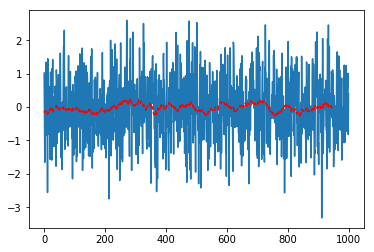

In [13]:
# X generated from a random series, without respect to time

X_stationary = np.random.randn(1000)
SMA_X_stationary = simple_moving_average(X_stationary, n=50)
plt.plot(X_stationary)
plt.plot(SMA_X_stationary, 'r--')  # Note how it stays "around zero"

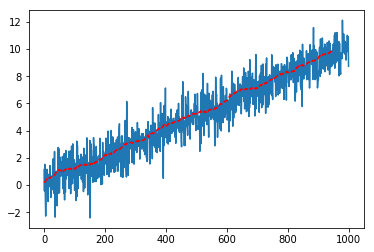

In [19]:
# X generated from a random series, but with time as an impact
X_non_stationary = 0.01 * np.arange(1000) + np.random.randn(1000)

SMA_X_non_stationary = simple_moving_average(X_non_stationary, n=50)
plt.plot(X_non_stationary)
plt.plot(SMA_X_non_stationary, 'r--')  # Note how the moving average clearly changes over time

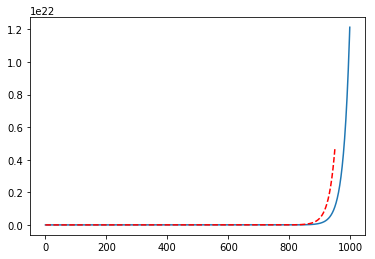

In [26]:
# X generated as a relationship to the lagged value, therefore having an inconsistent mean

c = 0.5
beta = 1.05
X_AR1 = [1, ]

for i in range(1, 1000):
    # Take the previous value, multiply it by beta and add c. Add some error
    new_data = c + beta * X_AR1[i-1] + np.random.randn(1) * 100
    X_AR1.append(new_data)

X_AR1 = np.array(X_AR1)
SMA_X_AR1 = simple_moving_average(X_AR1, n=50)

plt.plot(X_AR1)
plt.plot(SMA_X_AR1, 'r--')  # Note how the moving average clearly changes over time

### Exercise

1. Change the beta value in the above model to a value less than 1. What is different in this model?
2. Change to negative values above and below -1, what patterns do you see?

This type of model is an Autoregressive model, which we will look at later this module.

## Testing for Stationarity

There are a few mroe formal tests for stationarity. If we define $\gamma_k$ to be the covariance between $X_t$ and $X_{t-k}$, then let $\rho$ be the ratio of it and the variance in $X$. Specifically:

$\gamma_k = E[(X_t - \mu)(X_{t-k} - \mu)]$

$\rho_k = \frac{\gamma_k}{\gamma_0}$

Note that $\gamma_0$ is simply the variance at $X_t$, which is $\sigma^2$.

For a stationary time series, $\rho_k \rightarrow 0$ as $k \rightarrow \infty$, and further, if a time series is *white noise* then the values for $\rho_k$ are drawn from a normal distribution with a standard deviation of $\frac{1}{n}$. This means that we can test the significance of $\rho_k$ using a z distribution such that:

$\frac{\rho_k}{m} \sim N(0, 1)$

where $m= \sqrt{\frac{1}{n}}$

In [ ]:
from statsmodels.tsa.stattools import kpss

### Exercise

1. Statsmodels has a Kwiatkowski-Phillips-Schmidt-Shin test for stationarity. Using this test, check each of the three datasets above for stationarity (`X_stationary`, `X_non_stationary` and `X_AR1`).
2. Perform the same tests for the Augmented Dickey-Fuller (ADF) test, also in statsmodels

In [35]:
# Solutions
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, crit = kpss(X_stationary)

p_value > 0.05, p_value   # Accept hypothesis of stationarity

/home/rob/anaconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(True, 0.1)

In [36]:
kpss_stat, p_value, lags, crit = kpss(X_non_stationary)

p_value > 0.05, p_value  # Reject hypothesis of stationarity

/home/rob/anaconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(False, 0.01)

In [37]:
kpss_stat, p_value, lags, crit = kpss(X_AR1)

p_value > 0.05, p_value  # Reject hypothesis of stationarity

(False, 0.04910303483460027)

In [38]:
from statsmodels.tsa.stattools import adfuller

In [40]:
adf, p_value, *_ = adfuller(X_stationary)

In [43]:
p_value < 0.05, p_value  # Reject hypothesis of a unit root, which indicates stationary

(True, 5.964755180095018e-29)

### Further Research

Review the following reference for background information on the Adjusted Dickey-Fuller test:

    James G. MacKinnon, "1990, revised 2010". "Critical Values For Cointegration Tests," Working Paper 1227, Economics Department, Queen's University.
    
    Available: https://www.econ.queensu.ca/sites/econ.queensu.ca/files/qed_wp_1227.pdf
    

## Autoregressive models

An autoregressive model is one where the current value of a time series is dependent on the previous values, along with some $\beta$ value to create a linear relationship. Effectively, it is a lagged OLS, except that the variables are previous values of the predicted variable:

$X_t = c + \sum_{i=0}^n{\beta_i X_{t-n+1}} + u_t$

Where:
* $c$ is a constant. In previous OLS models, we simply added a constant to $X$ and another value for $\beta$, but that doesn't make sense for this data, as it is time-sequential. Here, we add it separately, but it has the same effect.
* $\beta$ is our linear coefficients as before, of which there are $n$ of them.
* $X_t$ is the value of $X$ at given time period $t$
* $u_t$ is our random error (i.i.d.) at time period $t$

The simplest model is AR(1), which is simply:

$X_t = c + \beta X_{t-1} + u_t$

In other words "take the previous time period's X, multiply it by $\beta$ and add c to it. Our error will be $u_t$.

In the earlier exercise, we saw that in an AR(1) model, then if $|\beta|<1$ then the model is stationary, otherwise it is not. Intuitively, we see this from the visualisation (try rerunning a few times to get a sense of the different shapes that happen when $\beta$ is above or below 1). Also, an intuitive sense is that if $|\beta|<1$, then there is a pressure towards zero, as $|\beta x| < |x|$ iff $|\beta|<1$. It is this "pressure towards zero" that doesn't happen if $|\beta| >= 1$, therefore the expected value does not tend to zero.

### Detrending data methods

There are two major types of stationary processes, i.e. the processes used to generate data. They are:

* **Trend Stationary Process (TSP)**: $X_t = \beta_1 + \beta_2 t + u_t$
* **Difference Stationary Process (DSP)**: $X_t = \beta X_{t-1} + u_t$

In both cases, $u_t$ is stationary, and in both cases, the $X$ itself variable is non-stationary.

To convert between a non-stationary process above to a stationary one, it is important do distinguish between whether your non stationary data is modelled using a TSP or a DSP. Stationary data can be modelled using the TSP model, and non-stationary data can be modeled using the DSP model.

A TSP is relatively straight-forward. We can convert a non-stationary variable into a stationary variable that is modelled as a TSP using by computing the difference at each time step:

${D}_t = X_t - \beta t$


Further to the above, data may need to be detrended multiple times to become stationary. A series that is already stationary is said to be integrated in I(0). If it needs to be detrended once to become stationary, it is I(1), twice is I(2) and so on (although it is rare to see higher values).

For combining variables, if you have many variables of form I(d), the result is also I(d). More generally, if you linearly combine variables of different orders (i.e. an I(1), I(2) and an I(3)), the result is of the order of this highest (I(3) in this example). 


### Exercise

1. Review the documentation for `statsmodels.tsa.tsatools.detrend`.
2. Remove the linear trends from the three datasets from above (`X_stationary`, `X_non_stationary` and `X_AR1`) and visualise the new data compared to the old data.
3. Perform the ADF test on the new resulting data and check for stationarity.


### Extended exercise

Detrending is an area with lots of different methods and techniques used. Oftentimes the context matters. Revie the documentaion for `scipy.signal.detrend` and review it's terminology compared to the statsmodels' version. Does a linear detrend in scipy correlate to a statsmodels detrending? Can you find another python package that includes detrending? What terminology does it use?